# IFT799 - TP1 : ABR (Tahar AMAIRI & Corentin POMMELEC)


## a. Importing the JSON file as a data frame

In [1]:
import matplotlib.patches as mpatches
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import calendar
import imageio # pip install imageio
import os

In [2]:
# The JSON file is very big (~ 10 GB), so it will be loaded as chunks
with pd.read_json('./Books.json', lines=True, chunksize=100000) as jsonChunks:
    dfAll = pd.DataFrame() # data frame containing all the JSON
    dfScore = pd.DataFrame() # data frame containing the score matrix
    chunkLimit = 10 # amount of chucks to load and add to the data frame
    count = 0 # counter

    # read each chunk
    for chunk in jsonChunks:
        if count >= chunkLimit: # break if the chunk limit is exceeded 
            break
        
        tmp = pd.DataFrame() # temporary data frame to save the score matrix for the current chunk
        
        # iterate over each score
        for i in range(1,6):
            # get the score matrix for the current "i" score
            scoreChunk = chunk[chunk['overall'] == i].asin.value_counts().to_frame().transpose()
            # concatenate to the tmp data frame
            tmp = pd.concat([tmp,scoreChunk], axis=0).fillna(0)
        
        dfAll = pd.concat([dfAll, chunk], axis=0) # concatenate to the dfAll data frame
        dfScore = dfScore.add(tmp, fill_value=0) # sum up to the df
        count += 1 # increment the counter
        
dfAll = dfAll.copy() # de-fragmented the data frame for better performance
dfScore = dfScore.copy() # de-fragmented the data frame for better performance

dfScore = dfScore.astype(int) # cast to int
dfScore.index = ["Ratings {} ☆".format(s) for s in range(1,6)] # set score index
dfScore # output the data frame

,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0307475468,0307475549,0307475735,0307475913,0307475956,0307475999,0307476014,0307476049,0307476065,0307476073
Ratings 1 ☆,6,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,3,6,0,1,18
Ratings 2 ☆,4,4,0,0,0,0,0,1,0,0,...,2,0,0,8,1,1,8,1,1,26
Ratings 3 ☆,8,2,0,0,1,0,2,0,5,1,...,6,1,0,3,1,3,13,2,0,51
Ratings 4 ☆,15,10,2,0,0,1,1,2,3,0,...,7,2,4,11,1,11,27,4,2,129
Ratings 5 ☆,173,2,13,7,5,13,9,3,6,4,...,9,1,9,11,2,23,33,17,11,223


### a.1 Compute the score of each book

In [3]:
# Computing the weighted mean (i.e the score)
def getAverageScore(dfScore):
    scoreDict = dict()
    score = np.arange(1,6)

    for book in dfScore.columns:
        bookScore = np.array(dfScore[book])
        scoreDict[book] = [np.dot(bookScore,score) / dfScore[book].sum(), dfScore[book].sum()]

    return pd.DataFrame(scoreDict, index=["Mean score", "Number of ratings"])

dfAverageScore = getAverageScore(dfScore)
dfAverageScore

,000100039X,0001055178,0001473123,0001473727,0001473905,0001712772,000171287X,0001714538,0002005395,0002006715,...,0307475468,0307475549,0307475735,0307475913,0307475956,0307475999,0307476014,0307476049,0307476065,0307476073
Mean score,4.674757,3.555556,4.625,5.0,4.666667,4.666667,4.583333,3.714286,4.071429,4.6,...,3.958333,3.4,4.692308,3.676471,3.8,4.219512,3.83908,4.541667,4.4,4.147651
Number of ratings,206.000000,18.000000,16.000,7.0,6.000000,15.000000,12.000000,7.000000,14.000000,5.0,...,24.000000,5.0,13.000000,34.000000,5.0,41.000000,87.00000,24.000000,15.0,447.000000


### a.2 Sort the books (best or worst)

In [4]:
n = 10 # the number of books to be shownQ
# Sorting the data frame in the ascending order
dfAverageScoreSorted = dfAverageScore.sort_values(by="Mean score", axis=1)

In [5]:
# Printing the n worst books
def getWorstBooks(dfAverageScoreSorted, n):
  if(len(dfAverageScoreSorted.columns) < n):
    n = len(dfAverageScoreSorted.columns)
  idx = np.arange(n)
  return dfAverageScoreSorted.iloc[:,idx]
  
getWorstBooks(dfAverageScoreSorted, 10)

,0071481478,006000455X,0071393080,006052846X,0061378844,0079137407,0061056103,0062513206,0307278018,013237045X
Mean score,1.0,1.214286,1.333333,1.354839,1.5,1.5,1.571429,1.6,1.6,1.6
Number of ratings,6.0,14.000000,6.000000,31.000000,12.0,6.0,7.000000,5.0,5.0,5.0


In [6]:
# Printing the n best books
def getBestBooks(dfAverageScoreSorted, n):
  if(len(dfAverageScoreSorted.columns) < n):
    n = len(dfAverageScoreSorted.columns)
  idx = np.arange(-1, -n-1, -1)
  return dfAverageScoreSorted.iloc[:,idx]
  
getBestBooks(dfAverageScoreSorted, 10)

,0140189882,0140266313,015200470X,0062043935,030013990X,0300139896,0071423583,0060257016,0130856347,0142414492
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,5.0,6.0,6.0,5.0,7.0,5.0,8.0,8.0,6.0,7.0


### a.3 1st quarter of the most popular books

In [7]:
# Getting the 1st quarter of the most popular books
def getFirstQuarterBestBooks(dfAverageScoreSorted):
  quarter = np.round(0.25 * dfAverageScoreSorted.shape[1])
  idx = np.arange(-1, -(quarter + 1), -1)
  return dfAverageScoreSorted.iloc[:,idx]
  
getFirstQuarterBestBooks(dfAverageScoreSorted)

,0140189882,0140266313,015200470X,0062043935,030013990X,0300139896,0071423583,0060257016,0130856347,0142414492,...,014044615X,0307275167,0007173687,0061059064,0062049879,0141331984,0060783389,0240812174,0062201255,0156027712
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.563549,4.563528,4.563492,4.56338,4.563177,4.562874,4.5625,4.5625,4.5625,4.5625
Number of ratings,5.0,6.0,6.0,5.0,7.0,5.0,8.0,8.0,6.0,7.0,...,417.000000,669.000000,126.000000,71.00000,277.000000,167.000000,16.0000,32.0000,16.0000,16.0000


### a.4 Comparison of the appreciation between two books

In [8]:
# Direct comparison by score
def getBestOfTwoBooks(book1, book2, dfAverageScore):
  if book1 in dfAverageScore.columns and book2 in dfAverageScore.columns:
    res = str

    if dfAverageScore[book1][0] > dfAverageScore[book2][0]:
      res = "{} has a better score than {}".format(book1,book2)
    elif dfAverageScore[book1][0] < dfAverageScore[book2][0]:
      res = "{} has a better score than {}".format(book2,book1)
    else:
      res = "They have the same mean score"

    res += "\n-> {} : mean score = {}, number of reviews = {}".format(book1, dfAverageScore[book1][0], dfAverageScore[book1][1])
    res += "\n-> {} : mean score = {}, number of reviews = {}".format(book2, dfAverageScore[book2][0], dfAverageScore[book2][1])
    print(res)

  else:
    raise ValueError("One of the books does not exist")

# collects two random books
book1 = dfAverageScore.sample(n=1,axis='columns').columns[0]
book2 = dfAverageScore.sample(n=1,axis='columns').columns[0]
getBestOfTwoBooks(book1, book2, dfAverageScore)

0060095563 has a better score than 0061210064
-> 0060095563 : mean score = 4.85, number of reviews = 20.0
-> 0061210064 : mean score = 4.5, number of reviews = 6.0


### a.6 Box plot 

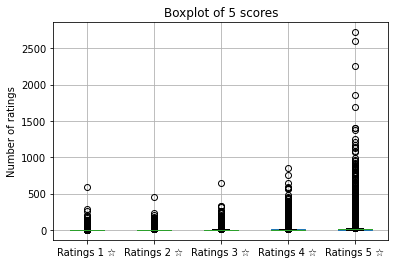

In [9]:
plt.title('Boxplot of 5 scores')
dfScore.transpose().boxplot(ylabel="Number of ratings"); # the diagram is too large to be analyzed

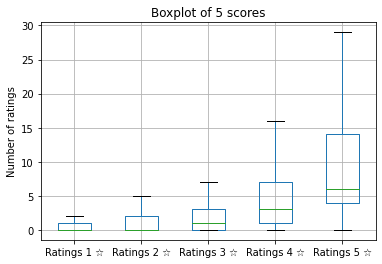

In [10]:
plt.title('Boxplot of 5 scores')
dfScore.transpose().boxplot(ylabel="Number of ratings", showfliers=False); # without outliers it can be analyzed

## b. Principal component analysis (PCA)


### b.1 Computing the PCA

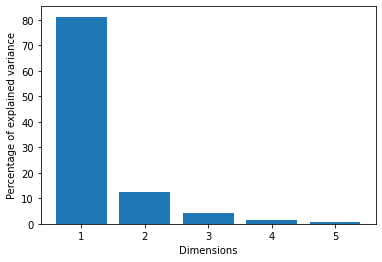

In [11]:
# Normalizing the data and computing the PCA
dfScoreNorm = (dfScore.transpose() - dfScore.transpose().mean()) / dfScore.transpose().std()
eigVal, eigVec = np.linalg.eig(dfScoreNorm.corr())

# Plotting the variance explained by each dimension
explainedVariance = (eigVal / np.sum(eigVal)) * 100
plt.ylabel('Percentage of explained variance')
plt.xlabel('Dimensions')
plt.bar(range(1,6), explainedVariance)
plt.show()

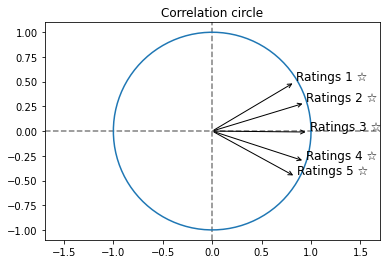

In [12]:
# From https://www.kaggle.com/code/karimsaieh/pca-principal-component-analysis-without-sklearn
# Only to plot the correlation circle
PC1 = dfScoreNorm.dot(eigVec[:,0])
PC2 = dfScoreNorm.dot(eigVec[:,1])

fig, ax = plt.subplots()

for i in range(dfScoreNorm.shape[1]):
    x = np.corrcoef(PC1, dfScoreNorm[dfScoreNorm.columns[i]])[0,1]
    y = np.corrcoef(PC2, dfScoreNorm[dfScoreNorm.columns[i]])[0,1]

    ax.annotate("", xy= (x,y), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))
    ax.annotate(dfScoreNorm.columns[i], (x+0.02,y+0.02), size=12)

ax.set_title('Correlation circle')
ax.axhline(y=0, color="grey", linestyle="--")
ax.axvline(x=0, color="grey", linestyle="--")

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.show()

In [13]:
# Projecting the data into the new plan 
dfScoreProj = dfScoreNorm.dot(eigVec[:,:2])
dfScoreProj.columns = ['x', 'y']
dfScoreProj

,x,y
000100039X,1.830373,-1.104765
0001055178,-0.107779,0.131628
0001473123,-0.491978,0.030017
0001473727,-0.636003,0.029927
0001473905,-0.609010,0.048822
...,...,...
0307475999,0.075679,0.019292
0307476014,1.556886,0.306848
0307476049,-0.331754,-0.083101
0307476065,-0.435611,0.104638


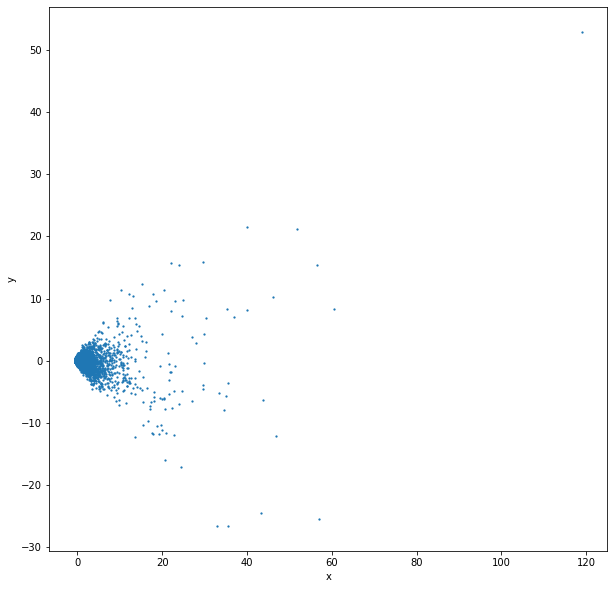

In [14]:
# Plotting the data
dfScoreProj.plot(x='x', y='y', kind='scatter', figsize=(10,10), s=1.5)
plt.show()

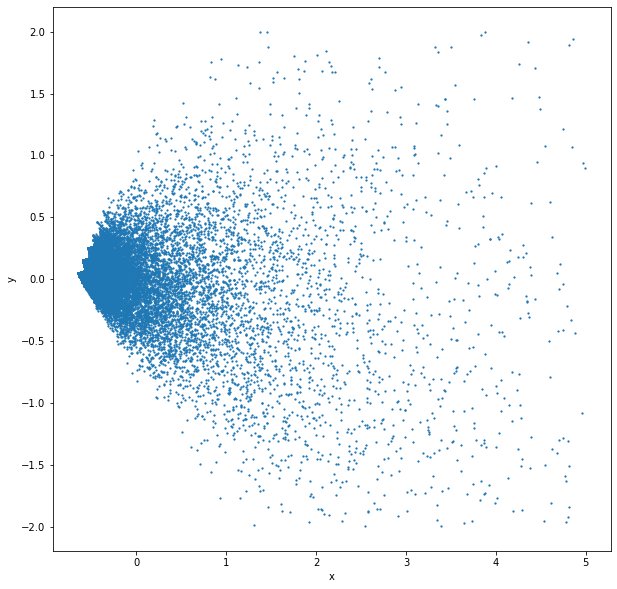

In [15]:
# Removing outlier points for a better view
dfScoreProjTrim = dfScoreProj.drop(dfScoreProj[(dfScoreProj.y < -2) | (dfScoreProj.y > 2) | (dfScoreProj.x > 5)].index)
dfScoreProjTrim.plot(x='x', y='y', kind='scatter', figsize=(10,10), s=1.5)
plt.show()

### b.2 Coloring the scatter plot

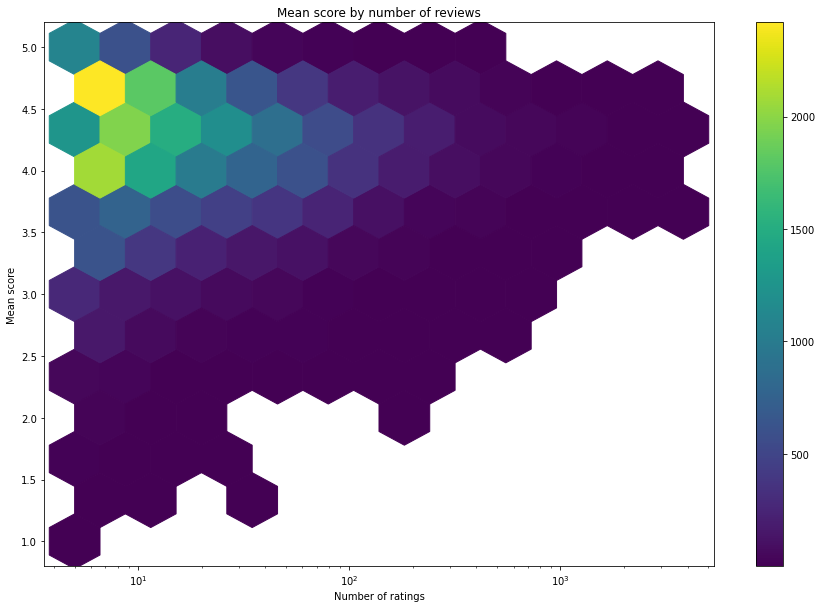

In [16]:
# Plotting the score against the number of reviews
dfAverageScore.transpose().plot(x="Number of ratings", y='Mean score', kind='hexbin', xscale='log', 
                         cmap='viridis', gridsize=12, mincnt=1, figsize=(15,10), 
                         sharex=False, title="Mean score by number of reviews")
plt.show()

In [17]:
# Computing Bayesian average : https://fulmicoton.com/posts/bayesian_rating/
def getBayesianScore(dfAverageScore, C, m):
    bayesianDict = dict()

    for book in dfAverageScore.columns:
        bayesianAverage = (C*m + dfAverageScore[book][0] * dfAverageScore[book][1]) / (C + dfAverageScore[book][1])
        bayesianDict[book] = [bayesianAverage, dfAverageScore[book][1]]

    return pd.DataFrame(bayesianDict, index=["Bayesian score", "Number of ratings"])

C = 20
m = 4.0
dfBayesianScore = getBayesianScore(dfAverageScore, C, m)

# Checking the new ranking
dfBayesianScore.sort_values(by="Bayesian score", axis=1, ascending=False)

,0195067142,0061906220,0060256672,0062225227,0152056610,0060525614,0140502343,029764680X,0141345713,0307010856,...,0143059335,0099451956,0061056383,0141004924,0060988649,0060014342,0061097934,006052846X,0143058266,0143059114
Bayesian score,4.846473,4.811429,4.804878,4.790323,4.781818,4.778846,4.778409,4.776758,4.766912,4.766234,...,2.806723,2.798113,2.746032,2.726708,2.719512,2.661765,2.603774,2.392157,2.337607,2.312169
Number of ratings,462.000000,155.000000,185.000000,228.000000,90.000000,84.000000,156.000000,307.000000,1340.000000,211.000000,...,218.000000,510.000000,43.000000,302.000000,62.000000,116.000000,33.000000,31.000000,214.000000,169.000000


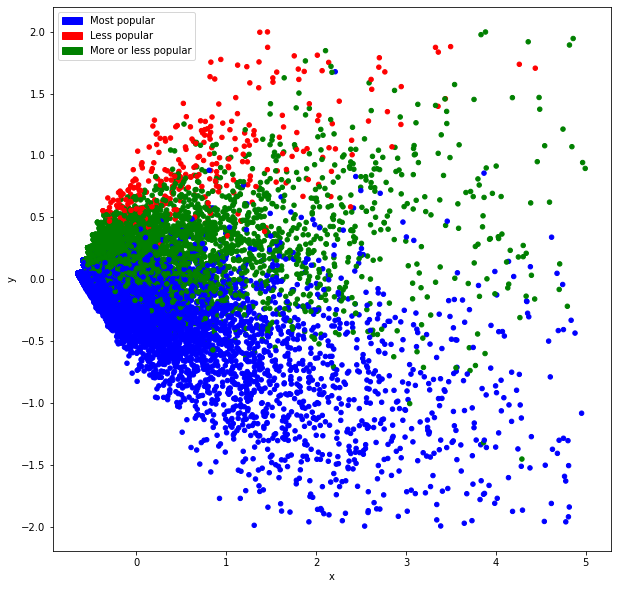

In [18]:
# Plotting the cluster
color = list()
cluster = {"blue" : list(), "red" : list(), "green" : list()}

for book in dfScoreProjTrim.index:
    if dfBayesianScore[book][0] > 4.0:
        color.append("blue")
        cluster["blue"].append(book)
    elif dfBayesianScore[book][0] < 3.5:
        color.append("red")
        cluster["red"].append(book)
    else:
        color.append("green")
        cluster["green"].append(book)

dfScoreProjTrim.plot(x='x', y='y', kind='scatter', figsize=(10,10), color=color)

legend = [mpatches.Patch(color='blue', label='Most popular'),
          mpatches.Patch(color='red', label='Less popular'),
          mpatches.Patch(color='green', label='More or less popular')]

plt.legend(handles=legend)
plt.show()

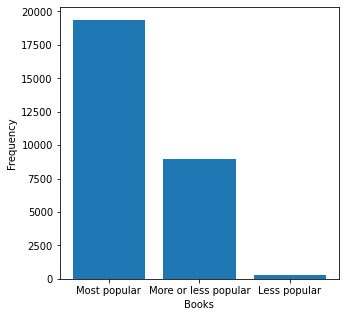

In [19]:
# Plotting histogram
x = ["Most popular", "More or less popular", "Less popular"]
y = [color.count("blue"), color.count("green"), color.count("red")]

plt.figure(figsize=(5,5))
plt.xlabel('Books')
plt.ylabel('Frequency')
plt.bar(x, y, align='center');

### b.3 Finding the center of each group

In [20]:
# Computing the center of each cluster
clusterCoord = {"x" : list(), "y" : list()}

for c, bookList in cluster.items():
    x = 0.0
    y = 0.0
    dfCoord = dfScoreProj.loc[bookList].transpose()

    for book in dfCoord.columns:
        x += dfCoord[book][0]
        y += dfCoord[book][1]
    
    x = x / len(bookList)
    y = y / len(bookList)

    clusterCoord["x"].append(x)
    clusterCoord["y"].append(y)

    print("{} cluster coordinates : ({},{})".format(c,x,y))

blue cluster coordinates : (-0.25333116763695634,-0.07875410932765767)
red cluster coordinates : (0.7788944514461678,0.930929138190557)
green cluster coordinates : (-0.08630922355634271,0.17900556196284914)


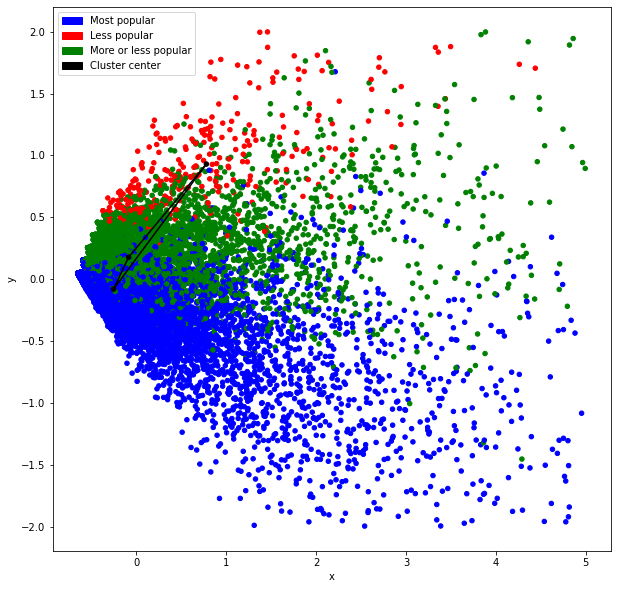

In [21]:
# Plotting the centers
dfClusterCoord = pd.DataFrame(clusterCoord, index=["blue","red","green"])
dfClusterCoord = pd.concat([dfScoreProjTrim,dfClusterCoord], axis=0)

colorCluster = color + ["black","black","black"]
legendCluster = legend + [mpatches.Patch(color='black', label='Cluster center')]

ax = dfClusterCoord.plot(x='x', y='y', kind='scatter', figsize=(10,10), color=colorCluster)
ax.plot([dfClusterCoord.loc["red"][0], dfClusterCoord.loc["green"][0]],
        [dfClusterCoord.loc["red"][1], dfClusterCoord.loc["green"][1]], color="black")

ax.plot([dfClusterCoord.loc["green"][0], dfClusterCoord.loc["blue"][0]],
        [dfClusterCoord.loc["green"][1], dfClusterCoord.loc["blue"][1]], color="black")

ax.plot([dfClusterCoord.loc["blue"][0], dfClusterCoord.loc["red"][0]],
        [dfClusterCoord.loc["blue"][1], dfClusterCoord.loc["red"][1]], color="black")

plt.legend(handles=legendCluster)
plt.show()

## c. Monthly review

In [22]:
# Extract from a data frame the score matrix
def extractScore(df):
    res = pd.DataFrame()
    
    for i in range(1,6):
        score = df[df['overall'] == i].asin.value_counts().to_frame().transpose()
        res = pd.concat([res,score], axis=0).fillna(0)

    res.index = ["Score = {}".format(s) for s in range(1,6)]
    return res.copy()

# Filters the initial data frame (dfAll) by the specified year
# and creates a new score matrix for each month of that year 
def extractByYear(dfAll, year):
    dfAll = dfAll[dfAll['reviewTime'].str.contains(str(year))].reset_index() # Keep the year of interest

    if dfAll.shape[0] == 0:
        raise ValueError("The specified year does not exist in the dataset !")

    dfAll['unixReviewTime'] = pd.to_datetime(dfAll['unixReviewTime'], unit='s')
    
    monthDict = {i : list() for i in range(1,13)}

    for i in range(0,dfAll.shape[0]):
        unixTime = dfAll['unixReviewTime'][i]
        monthDict[unixTime.month].append(i)

    res = dict()

    # fill in the contents of the 12 monthly data frames
    for month, l in monthDict.items():
        if l:
            tmp = dfAll[dfAll.index.isin(l)]
            res[month] = extractScore(tmp)
            
    return res

### c.1 Compute the score of each book by month

In [23]:
year = 2013 # the year to be extracted from dfAll

# Extracting
monthDict = extractByYear(dfAll, year)

# Computing the weighted mean (i.e the score) by month
monthAverageScoreDict = dict()

for month, dfScoreMonth in monthDict.items():
    monthAverageScoreDict[month] = getAverageScore(dfScoreMonth)
    print(calendar.month_name[month])
    display(monthAverageScoreDict[month])

January


,006226768X,0151008116,0263899403,006230240X,0307346609,0007230206,0060175400,0061147958,0061231401,0061493341,...,0060935618,0099283212,0060935340,0099287595,0099297701,0099421860,0060934573,0099429330,0060934506,0141182342
Mean score,4.05,4.257143,4.167203,4.228495,4.065574,3.588235,4.12,3.857143,4.236842,3.578947,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,80.00,210.000000,311.000000,372.000000,61.000000,51.000000,25.00,14.000000,38.000000,19.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


February


,0141326085,0263899403,0062065246,0062082353,0151008116,006199104X,0007230206,0307263991,0307346609,006226768X,...,0071777652,0071791523,0071780785,007178084X,0071781250,0060871342,0060871318,0071786988,0071790071,0062511319
Mean score,4.288344,3.9875,4.039604,4.46789,4.120968,4.043011,3.666667,2.0,3.976744,4.235294,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,326.000000,160.0000,101.000000,109.00000,124.000000,93.000000,33.000000,8.0,43.000000,51.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


March


,0002247399,0007230206,0263899403,0195170776,0141326085,0151008116,0062065246,0062248472,0062231707,0062124269,...,0064410153,0002005395,0064430200,0064430219,0064430227,0064431126,0064431290,0064431622,0064432521,0140012869
Mean score,3.909091,3.074074,4.148387,3.166667,4.271565,4.37037,4.22449,4.197674,2.6,3.87037,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,55.000000,27.000000,155.000000,12.000000,313.000000,135.00000,98.00000,86.000000,10.0,54.00000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


April


,0061928127,0060098902,0002247399,006226768X,006208576X,006211851X,0062218875,006222087X,0140437614,0062217208,...,0071809953,0060927623,0071812334,0072121246,0072124903,0072262613,0072874899,0072977434,0073135542,0062513362
Mean score,3.761905,4.125,4.284091,3.653846,3.086957,2.769231,2.888889,3.0,3.0,3.8,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,42.000000,56.000,88.000000,26.000000,23.000000,13.000000,9.000000,10.0,6.0,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


May


,0062292129,0195170776,0062059963,0060098902,0199571120,0307341569,0062104527,030728090X,0062200577,0060987103,...,0060936924,0060936770,0094801606,0060936193,0099244527,0099270234,009928099X,0060934573,0099285568,0062700847
Mean score,4.467742,2.5,3.896552,4.211538,2.5,3.733333,2.285714,4.413793,4.58156,4.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,124.000000,10.0,87.000000,208.000000,8.0,45.000000,7.000000,29.000000,141.00000,20.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


June


,0062071475,0307346609,0007327064,0060098902,0143125311,0062292129,0062222961,0062008110,006224812X,0263899403,...,0060541431,0062238833,0060540907,0062240595,0060540087,0060539860,0060539755,0062245295,0062245821,013011510X
Mean score,3.263158,4.009709,4.339181,4.15,3.965116,3.888889,3.375,3.814815,1.6,3.981132,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,19.000000,103.000000,171.000000,220.00,86.000000,45.000000,16.000,27.000000,5.0,53.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


July


,0062224840,0062255657,0062280546,0007230206,0062120395,0062222961,0062274724,0143123238,0061041696,0062071475,...,0062083023,0062089463,0062083619,0062084739,0007284926,0062088025,0062088068,0062088084,0062088157,0064409643
Mean score,3.367347,4.270903,3.625,3.535714,4.058333,3.857143,3.461538,4.013333,3.885714,4.095238,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,49.000000,299.000000,24.000,28.000000,120.000000,21.000000,13.000000,75.000000,35.000000,21.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


August


,0143123238,0062255657,0062303996,0307272591,0061928127,0062224840,0061692034,0061122416,0007230206,0142181498,...,0062206230,0060393491,0060392827,0062206796,0062209698,0062210025,0062211102,0060392428,0060391901,0072127481
Mean score,3.643312,3.970954,3.314286,4.097826,3.666667,3.745763,3.25,4.068966,3.769231,3.725,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,157.000000,241.000000,35.000000,184.000000,51.000000,59.000000,16.00,29.000000,39.000000,40.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


September


,0062247506,0307272591,0062224840,0230769152,0062255657,0061458570,0007493754,0141188936,0143123238,015206396X,...,0060565411,0062228323,0060565373,0060565160,0060563486,0062236520,0060563079,0060560789,0062233084,0099472325
Mean score,3.129032,3.807229,3.263158,4.333333,4.117284,2.928571,4.12,3.818182,3.619048,2.888889,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,31.000000,83.000000,38.000000,162.000000,162.000000,14.000000,75.00,22.000000,168.000000,9.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


October


,0007444117,0141339195,0224098101,0062255657,0230769152,0263899403,0143123238,0307263991,0099911701,0307292134,...,0060292903,0062198793,0060256753,0062202928,0062203215,0060262656,0062205838,0062206362,0062206451,0071753931
Mean score,3.033333,4.541045,3.491525,4.096774,4.307888,3.916667,3.793814,1.4,4.0,4.447368,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,570.000000,268.000000,59.000000,93.000000,393.000000,72.000000,97.000000,5.0,16.0,38.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


November


,0007444117,0062292889,0224098101,0062107313,0007442920,0230769152,0062255657,0141339195,0307265749,030682308X,...,0062233084,0062233165,0062234463,0062236806,0062242563,0062238396,0062240595,0062241338,0060566175,0062288385
Mean score,3.242009,2.704545,3.352941,3.616279,4.348148,4.219178,4.244444,4.514706,3.782609,3.111111,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,657.000000,44.000000,68.000000,86.000000,135.000000,146.000000,90.000000,136.000000,69.000000,9.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


December


,0007444117,0062292889,0062107313,0143123238,0062124269,030682308X,0224098101,0230769152,006204964X,0062083481,...,0060542349,0060545690,0062300385,0060545623,0060545607,0060545542,0060544880,0060542977,0060542381,0062503731
Mean score,3.3875,3.673913,3.59292,3.631579,3.413793,2.785714,3.491525,4.17,3.0,2.818182,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,400.0000,46.000000,113.00000,76.000000,29.000000,14.000000,59.000000,100.00,10.0,11.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### c.2 Sort the books for each month (best or worst)

In [24]:
# Sorting the 12 data frames in the ascending order by score
monthAverageScoreSortedDict = dict()

for month, dfScoreMonth in monthAverageScoreDict.items():
  monthAverageScoreSortedDict[month] = dfScoreMonth.sort_values(by="Mean score", axis=1)

In [25]:
# Printing the three best books for each month
for month, dfScoreMonth in monthAverageScoreSortedDict.items():
    print(calendar.month_name[month])
    display(getBestBooks(dfScoreMonth, 3))

January


,0141182342,0143142941,0060667419
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


February


,0062511319,014241168X,0142196096
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


March


,0140012869,0306821559,0307035964
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


April


,0062513362,0060598972,0060646918
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


May


,0062700847,0307475395,0142000329
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


June


,013011510X,0141049588,0142420921
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


July


,0064409643,0230341896,0230341799
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


August


,0072127481,0306813491,0306811936
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


September


,0099472325,0142418188,0142419672
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


October


,0071753931,0142180688,0307381706
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


November


,0062288385,0142408433,0142407739
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


December


,0062503731,0060090383,0142427543
Mean score,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0


In [26]:
# Printing the three worst books for each month
for month, dfScoreMonth in monthAverageScoreSortedDict.items():
    print(calendar.month_name[month])
    display(getWorstBooks(dfScoreMonth, 3))

January


,0060560789,030737937X,0307378888
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


February


,0060516402,022613251X,0201442310
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


March


,0307275701,0307351718,0307335992
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


April


,0060760176,015602800X,015202168X
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


May


,0060014164,006000925X,0099324210
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


June


,0205050174,0140194711,0061234907
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


July


,015204714X,0141399961,0061840297
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


August


,0060087447,0140445692,0140513302
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


September


,0028641477,026387561X,0061827673
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


October


,0020826621,0123860016,0230613748
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


November


,0062127667,0140289526,0140286802
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


December


,0007503598,0230368891,0061825891
Mean score,1.0,1.0,1.0
Number of ratings,1.0,1.0,1.0


### c.3  1st quarter of the most popular books by month

In [27]:
# Getting the 1st quarter of the most popular books by month
for month, dfMonth in monthAverageScoreSortedDict.items():
    print(calendar.month_name[month])
    display(getFirstQuarterBestBooks(dfMonth))

January


,0141182342,0143142941,0060667419,006066567X,0143106716,0143105922,0143105825,0143105760,0143105396,0142410896,...,0061436860,006202051X,0061579173,0062006487,006144295X,0062019481,0061456438,0061456527,0062008382,0062008137
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


February


,0062511319,014241168X,0142196096,0142410357,0142409502,0142300209,0142402249,0142401978,0142401935,0142401544,...,0061854018,0061946524,0061961183,0061910244,0061445886,006145205X,0061452963,0061859362,0061455083,0061874175
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


March


,0140012869,0306821559,0307035964,0307021521,0307021416,0307021408,0007244576,0307021106,0307020460,0307001431,...,0061243418,0060890746,0060891270,0061241490,006124130X,0061241083,0061240273,0061239240,0061245607,0061239216
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


April


,0062513362,0060598972,0060646918,006063880X,006063524X,0142302309,0142301930,0142300853,0142300705,0142300616,...,006199023X,0140257314,0060815221,0140280464,0140280359,0060819359,0140274367,0140270590,0140269770,0140267719
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


May


,0062700847,0307475395,0142000329,006075737X,0141337184,0060759712,0141333391,0060759836,006075995X,0307475735,...,0062021737,0062021362,0061445886,0061434515,0061432644,0061374814,0061375330,0062049488,0061379204,006204835X
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


June


,013011510X,0141049588,0142420921,0142003344,0141180412,0142420603,0060000708,0141180145,0030769809,0060094354,...,0061170747,0061205346,0099269325,0099271478,0071362614,0099474468,0071444041,007179512X,0071798404,0071799664
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


July


,0064409643,0230341896,0230341799,0230341691,0231131577,0231134770,0231140509,0240823672,0240821084,0240820312,...,0060723238,0060619953,0060611413,0060567228,0060609176,0060584068,0060582731,0060579374,0060578114,006057786X
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


August


,0072127481,0306813491,0306811936,0306811359,0306810832,0306810581,0306808404,0306807874,0306806614,0306806541,...,0060958022,0060643412,0060931736,0060931957,0060937661,0061050318,0061059064,0060628618,006100345X,0060953667
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


September


,0099472325,0142418188,0142419672,0060012358,0141024712,006000925X,0060009314,0060011572,0141015357,0141016965,...,0099436760,0060512806,0099415372,0099288850,0099285568,009928099X,0099244721,0094801606,0060513136,0091943361
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


October


,0071753931,0142180688,0307381706,0025882201,0142180408,0307382435,0004723724,030738585X,0142180300,0142180289,...,0135080908,0135029805,0134572599,0133836878,0137019238,0133316033,0133142868,0133092569,013306476X,0132936526
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


November


,0062288385,0142408433,0142407739,0142407542,0142407380,0142407097,0060014342,0142406333,0142401048,0142406279,...,0061252301,0061251348,0061284424,0061234532,0061231770,0061173045,0061172111,006117114X,0061170747,0061153907
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


December


,0062503731,0060090383,0142427543,0142427489,0142427225,0060088877,0142426059,0142424722,0060087714,0142500046,...,0140434925,0140194967,0140434887,014043464X,0060505753,0140433392,014043268X,0060510609,0132312832,0140303332
Mean score,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
Number of ratings,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### c.4 Computing the PCA for each month

In [28]:
# Some functions

# Get the max, min for the x and y axes based on all the months
# (in order to have the same axes for each frame in the GIF)
def getAxesInterval(dfScoreProjList):
    xmin, xmax = dfScoreProjList[0]["x"].min(), dfScoreProjList[0]["x"].max()
    ymin, ymax = dfScoreProjList[0]["y"].min(), dfScoreProjList[0]["y"].max()

    for dfPCA in dfScoreProjList[1:]:
        if xmin > dfPCA["x"].min():
            xmin = dfPCA["x"].min()
        if xmax < dfPCA["x"].max():
            xmax = dfPCA["x"].max()
        if ymin > dfPCA["y"].min():
            ymin = dfPCA["y"].min()
        if ymax < dfPCA["y"].max():
            ymax = dfPCA["y"].max()

    return ([xmin,xmax],[ymin,ymax])

# Project the df score matrix into the pca plan
def projectData(dfScore, eigVec):
    dfScoreNorm = (dfScore.transpose() - dfScore.transpose().mean()) / dfScore.transpose().std()
    res = dfScoreNorm.dot(eigVec[:,:2])
    res.columns = ['x', 'y']
    return res
  
# Saves the PCA plot
def savePlot(dfScoreProj, dfBayesianScore, a, b, month, year, interval):
    color = list()

    for book in dfScoreProj.index:
        if dfBayesianScore[book][0] > a:
            color.append("blue")
        elif dfBayesianScore[book][0] < b:
            color.append("red")    
        else:
            color.append("green")
    
    title = str(year) + '-' + calendar.month_name[month]
    dfScoreProj.plot(x='x', y='y', kind='scatter', figsize=(10,10), color=color,
               title=title, xlim=interval[0], ylim=interval[1])

    legend = [mpatches.Patch(color='blue', label='Most popular'),
              mpatches.Patch(color='red', label='Less popular'),
              mpatches.Patch(color='green', label='More or less popular')]
    
    plt.title(title)
    plt.legend(handles=legend)
    plt.savefig("{}.png".format(title), bbox_inches='tight')
    plt.close()

# Plotting the data on a GIF format with one second frame per month
def createGIF(year, a, b, dfDict, inter, deleteImg):
    frames = []

    for month, dfList in dfDict.items():
        savePlot(dfList[0], dfList[1], a, b, month, year, inter)
        imgName = "{}-{}.png".format(year, calendar.month_name[month])
        frames.append(imageio.v2.imread(imgName));
        if deleteImg:
            os.remove(imgName)
        
    kargs = {'duration': 1}
    imageio.mimsave('{}.gif'.format(year), frames, 'GIF', **kargs)

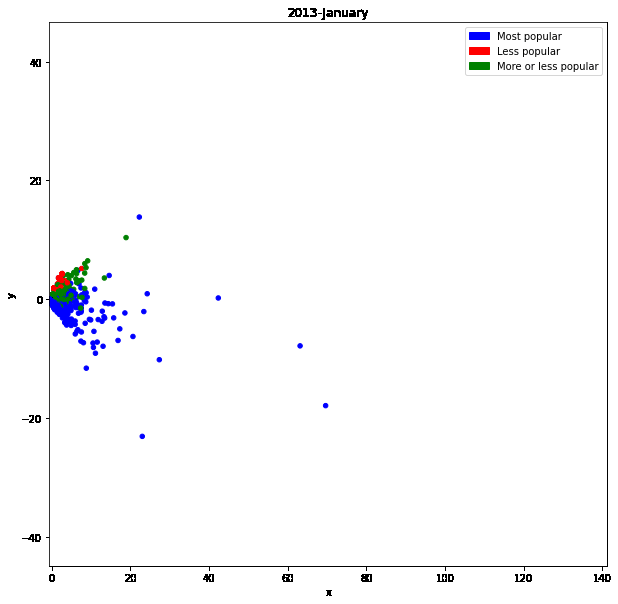

In [29]:
a = 4.0 # interval setting to classify a book in a cluster
b = 3.0 # equivalent in the wording to the interval [2.5, 3.5]
deleteImg = True # delete images during the generation of the GIF

monthScoreDict = extractByYear(dfAll, year)
dfDict = dict()

for month, dfScoreMonth in monthScoreDict.items():
    dfAverageScoreMonth = getAverageScore(dfScoreMonth)   
    C = dfAverageScoreMonth.iloc[1].quantile([0.25]).iloc[0] # based on the 1st quartile
    m = dfAverageScoreMonth.iloc[0].mean() # the mean of all average scores

    dfBayesianScoreMonth = getBayesianScore(dfAverageScoreMonth, C, m)
    dfScoreProjMonth = projectData(dfScoreMonth, eigVec)
    dfDict[month] = [dfScoreProjMonth, dfBayesianScoreMonth]

inter = getAxesInterval([dfDict[month][0] for month in dfDict.keys()])
createGIF(year, a, b, dfDict, inter, deleteImg)

Image('{}.gif'.format(year)) # display the GIF